# 1. Problematic

# 2. Data understanding

### 2.1. Import required libraries

In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import sklearn.naive_bayes
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import pickle
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
import gzip
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint



[nltk_data] Downloading package stopwords to C:\Users\Hedi
[nltk_data]     Aloulou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# check gpu availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


## 2.2. Data discovery

In [4]:
df = pd.read_csv("data.csv")
df.head()

,text,sentiment
0,حتى انا مايطلعوليش,1.0
1,NaN,0.0
2,بلاهي تحيا ألسي فتحي العكاري على الدور البو إل...,0.0
3,بلحق ماهوش راجل و مرتو ارجل منو و زاد طرد بنتو...,-1.0
4,وين الحلقة كاملة فولوجة 2,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9318 entries, 0 to 9317
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       9314 non-null   object 
 1   sentiment  4111 non-null   float64
dtypes: float64(1), object(1)
memory usage: 145.7+ KB


In [6]:
df.describe()

,sentiment
count,4111.000000
mean,0.192897
std,0.817097
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


# 3. Data analysis

## 3.1. Data interpretation

In [7]:
# count number of apperances of each class
df.sentiment.value_counts()

sentiment
 1.0    1845
 0.0    1214
-1.0    1052
Name: count, dtype: int64

In [8]:
df.shape

(9318, 2)

## 3.2. Data visualization

### 3.2.1. using bar chart

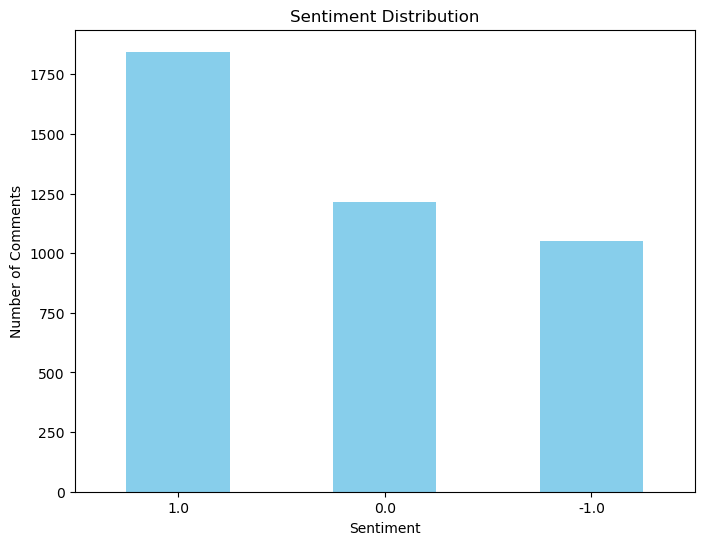

In [9]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.show()

### 3.2.2. using pie chart

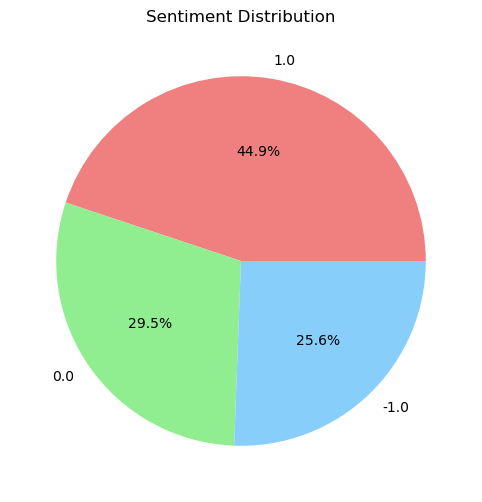

In [10]:
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightgreen', 'lightskyblue'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

### 3.2.3. using word Cloud

In [12]:
#comment_text = ' '.join(df['text'].astype(str).tolist())
#wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comment_text)

#plt.figure(figsize=(10, 6))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.title('Word Cloud for Comments')
#plt.axis('off')
#plt.show()

* our dataset has a lot of null values , so let's dive into preprocessing step !

# 4. Data preprocessing

## 4.1. Data cleaning 

In [13]:
df = df.dropna()

In [14]:
df = df.drop_duplicates()


In [15]:
# Define features and label
features = df['text']
labels = df['sentiment']

In [16]:
features

0                                      حتى انا مايطلعوليش
2       بلاهي تحيا ألسي فتحي العكاري على الدور البو إل...
3       بلحق ماهوش راجل و مرتو ارجل منو و زاد طرد بنتو...
4                               وين الحلقة كاملة فولوجة 2
5                                                 فلوجة ❤
                              ...                        
9301    كلما أشاهد حلقة جديدة، يتأكد لي أن هذا المسلسل...
9302    لم يعد هناك أي جاذبية في هذا المسلسل، فهو لا ي...
9303    يظهر هذا المسلسل علامات واضحة على الإعياء والإ...
9304    لا يمكنني التصديق أن هذا المسلسل ما زال مستمرً...
9306    يبدو أن هذا المسلسل قد فقد الهدف والتوجه، فلا ...
Name: text, Length: 4014, dtype: object

In [17]:
labels

0       1.0
2       0.0
3      -1.0
4       0.0
5       0.0
       ... 
9301   -1.0
9302   -1.0
9303   -1.0
9304   -1.0
9306   -1.0
Name: sentiment, Length: 4014, dtype: float64

In [18]:
# define text cleaning function

def clean_text(text):
    # Remove non-Arabic characters
    text = text.str.replace(r'[^\u0621-\u064A\s]', ' ', regex=True)  # Arabic Unicode range
    # Remove HTML tags
    text = text.str.replace(r'<.*?>', '', regex=True)
    # Remove multiple white spaces
    text = text.str.replace(r'\s+', ' ', regex=True)
    # Remove single characters except spaces
    text = text.str.replace(r'\b\w\b', '', regex=True)
    # Strip leading and trailing spaces
    text = text.str.strip()
    return text

In [19]:
# define function to preprocess text data

def preprocess_text(df):
    # Drop duplicate rows
    df.drop_duplicates(inplace=True)
    # Clean text
    df['text'] = clean_text(df['text'])
    # Keep only alphanumeric and space characters
    df['text'] = df['text'].apply(lambda x: ''.join(char for char in x if char.isnumeric() or char.isalpha() or char.isspace()))
    return df

In [20]:
df.head()

,text,sentiment
0,حتى انا مايطلعوليش,1.0
2,بلاهي تحيا ألسي فتحي العكاري على الدور البو إل...,0.0
3,بلحق ماهوش راجل و مرتو ارجل منو و زاد طرد بنتو...,-1.0
4,وين الحلقة كاملة فولوجة 2,0.0
5,فلوجة ❤,0.0


In [21]:
df = df.sample(frac=1).reset_index(drop=True)

In [22]:
df.head()

,text,sentiment
0,اناحالي تعيس اماحال المنجي اتعس واضحك ام...,1.0
1,هايلا 👍👍👏👏💞,1.0
2,شكون مازال يتفرج فيه 2023. أفضل سيتكوم ❤,0.0
3,مسلسل تمثل فيه دليلة مفتاح مستحيل ماينجحش شخصي...,1.0
4,شكون مازال يتفرج فيه 2023 الله ال❤❤,0.0


In [23]:
# define normalization_arabic function

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [24]:
df['text'] = clean_text(df['text'])
df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(normalize_arabic)
print(df['text'])

0       اناحالي تعيس اماحال المنجي اتعس واضحك اما محله...
1                                                   هايلا
2                        شكون مازال يتفرج فيه افضل سيتكوم
3       مسلسل تمثل فيه دليله مفتاح مستحيل ماينجحش شخصي...
4                            شكون مازال يتفرج فيه الله ال
                              ...                        
4009                                     جلطا مسكين ههههه
4010    كلما اشاهد حلقه جديده يزداد انزعاجي من هذا الم...
4011    ربي يرحمك خليتي وراك فراغ كبير  شكون اللي ما ي...
4012          العمل يفتقد الي العمق والتفاعل بين الشخصيات
4013                                        هههههههه روعه
Name: text, Length: 4014, dtype: object


## 4.2. Word Embedding

In [25]:
# download stop words and punkt
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Hedi
[nltk_data]     Aloulou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Hedi
[nltk_data]     Aloulou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 4.2.1. In LSTM

In [26]:
with gzip.open('cc.ar.300.vec.gz', 'rb') as f_in:
    with open('cc.ar.300.vec', 'wb') as f_out:
        f_out.write(f_in.read())

# Load FastText embeddings
embeddings_index = {}
with open('cc.ar.300.vec', encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [27]:
df_copy = df.copy()
# Function to get embedding for a sentence
def get_embedding(sentence):
    embedding = []
    for word in sentence.split():
        if word in embeddings_index:
            embedding.append(embeddings_index[word])
    return embedding

# Apply embedding to cleaned text and store in a new column named 'embedding'
df_copy['embedding'] = df_copy['text'].apply(get_embedding)

# Prepare data for LSTM
max_length = 100  # Maximum sequence length

# Pad sequences to the same length
X_lstm = pad_sequences(df_copy['embedding'], maxlen=max_length, padding='post', dtype='float32')  # Specify dtype=float32

y_lstm = df_copy['sentiment']

# Split data into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)



### 4.2.2. Casual models

In [28]:
arabic_stopwords = set(stopwords.words('arabic'))

# Initialization of the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Tokenize Arabic text using word_tokenize from NLTK
df['text'] = df['text'].apply(lambda x: word_tokenize(x))

# Join tokenized text back into sentences
df['text'] = df['text'].apply(lambda x: ' '.join(x))

# Apply the vectorizer on text
X = vectorizer.fit_transform(df['text']).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, df['text'], test_size=0.2, random_state=42)

# 5. Machine learning

## 5.1. LSTM

In [30]:


# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_length, 300))))
model.add(Dense(units=1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the best validation accuracy
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train model
history = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), callbacks=[checkpoint])

# Save model architecture to a file
with open('model_architecture.pkl', 'wb') as f:
    pickle.dump(model.to_json(), f)
# Save model weights to a file
model.save_weights('model_weights.h5')

# Save model training configuration to a file
with open('model_config.pkl', 'wb') as f:
    pickle.dump(history.history, f)
Y_pred_LSTM=model.predict(X_test_lstm)

Epoch 1/20
101/101 [==============================] - ETA: 0s - loss: -0.0392 - accuracy: 0.3407
Epoch 1: val_accuracy improved from -inf to 0.41220, saving model to best_model.h5
101/101 [==============================] - 84s 759ms/step - loss: -0.0392 - accuracy: 0.3407 - val_loss: -0.6487 - val_accuracy: 0.4122
Epoch 2/20
101/101 [==============================] - ETA: 0s - loss: -1.3295 - accuracy: 0.4226
Epoch 2: val_accuracy improved from 0.41220 to 0.46575, saving model to best_model.h5
101/101 [==============================] - 75s 742ms/step - loss: -1.3295 - accuracy: 0.4226 - val_loss: -1.9795 - val_accuracy: 0.4658
Epoch 3/20
101/101 [==============================] - ETA: 0s - loss: -2.6028 - accuracy: 0.4232
Epoch 3: val_accuracy did not improve from 0.46575
101/101 [==============================] - 74s 732ms/step - loss: -2.6028 - accuracy: 0.4232 - val_loss: -3.3769 - val_accuracy: 0.4608
Epoch 4/20
101/101 [==============================] - ETA: 0s - loss: -4.2391 - a

## 5.2. Casual models

In [31]:
# Split the DataFrame indices into train and test indices
train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Assign the corresponding labels to y_train and y_test using the indices
y_train = df.loc[train_indices, 'sentiment']
y_test = df.loc[test_indices, 'sentiment']

In [32]:
neural = MLPClassifier(hidden_layer_sizes=(100,150),activation='logistic',solver='adam')
linear_svm = SVC(kernel='linear')
rbf_svm = SVC(kernel='rbf')
sgd_svm = SVC(kernel='sigmoid')
poly_svm = SVC(kernel='poly',degree=2)
gnb = GaussianNB()

#Training of ML algorithms
neural.fit(X_train,y_train)
linear_svm.fit(X_train,y_train)
rbf_svm.fit(X_train,y_train)
sgd_svm.fit(X_train,y_train)
poly_svm.fit(X_train,y_train)
gnb.fit(X_train,y_train)

#prediction
Y_pred_neural = neural.predict(X_test)
Y_pred_linear_svm = linear_svm.predict(X_test)
Y_pred_rbf = rbf_svm.predict(X_test)
Y_pred_sgd = sgd_svm.predict(X_test)
Y_pred_poly = poly_svm.predict(X_test)
Y_pred_gnb = gnb.predict(X_test)


# 6. Performance evaluation

## 6.1. LSTM performance evaluation

In [ ]:
tunisian_series_comments = [
    "مسلسل 'وادي الذئاب' من أفضل المسلسلات التونسية التي شاهدتها.",
    "لقد استمتعت كثيراً بمتابعة مسلسل 'علاء الدين'.",
    "ما رأيك في مسلسل 'حكايات تونسية'؟",
    "أنا متحمس جداً للموسم الجديد من مسلسل 'سامحيني'.",
    "ما رأيك في الأداء الفني في مسلسل 'دار الزين'؟",
    "أحببت شخصية 'محمد باش' في مسلسل 'الوعد'.",
    "لم يعجبني السيناريو في مسلسل 'ولد الغلابة'.",
    "ما هي أفضل مسلسلات التاريخ التونسي برأيك؟",
    "من المسلسلات التونسية التي لا يمكنني نسيانها: 'سبع صنايع'.",
    "مسلسل 'الأب الروحي' يعكس الحياة اليومية في تونس بشكل جميل.",
    "هل شاهدت مسلسل 'شوفلي حل'؟ إذاً، ما رأيك فيه؟",
    "ما هو مسلسلك التونسي المفضل؟",
    "السيناريو يفتقد إلى الجاذبية والتوتر اللازمين.",
    "التمثيل يبدو مبتذلاً وغير مقنع."
]

# Iterate over the list of comments
for comment in tunisian_series_comments:
    # Preprocess the comment
    processed_comment = preprocess_text(comment)

    # Tokenize and convert to embedding
    embedding = get_embedding(processed_comment)

    # Pad sequence
    padded_embedding = pad_sequences([embedding], maxlen=max_length, padding='post', dtype='float32')

    # Predict sentiment
    prediction = model.predict(padded_embedding)

    # Convert prediction to sentiment label
    if prediction > 0.5:
        sentiment_label = 'Positive'
    elif prediction < -0.5:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'

    # Print the comment and its predicted sentiment
    print("Comment:", comment)
    print("Predicted Sentiment:", sentiment_label)
    print()


## 6.2. Machine learning algorithms evaluation

In [33]:
print("************** Perfomance of neural network ******************")
print(classification_report(y_test, Y_pred_neural))
print("************** Perfomance of linear svm ******************")
print(classification_report(y_test, Y_pred_linear_svm))
print("************** Perfomance of rbf ******************")
print(classification_report(y_test, Y_pred_rbf))
print("************** Perfomance of sgd ******************")
print(classification_report(y_test, Y_pred_sgd))
print("************** Perfomance of poly ******************")
print(classification_report(y_test, Y_pred_poly))
print("************** Perfomance of gnb ******************")
print(classification_report(y_test, Y_pred_gnb))


************** Perfomance of neural network ******************
              precision    recall  f1-score   support

        -1.0       0.79      0.62      0.69       188
         0.0       0.59      0.62      0.60       255
         1.0       0.74      0.80      0.77       360

    accuracy                           0.70       803
   macro avg       0.71      0.68      0.69       803
weighted avg       0.70      0.70      0.70       803

************** Perfomance of linear svm ******************
              precision    recall  f1-score   support

        -1.0       0.83      0.69      0.75       188
         0.0       0.65      0.66      0.66       255
         1.0       0.77      0.83      0.80       360

    accuracy                           0.74       803
   macro avg       0.75      0.73      0.74       803
weighted avg       0.75      0.74      0.74       803

************** Perfomance of rbf ******************
              precision    recall  f1-score   support

        -

# 7. Deployment

In [35]:
pickle.dump(vectorizer,open('vectorizer.pickle',"wb"))
pickle.dump(sgd_svm,open('best_model_sgd.pickle',"wb"))